<a href="https://colab.research.google.com/github/kh-ops69/ML_NLP/blob/master/sentiment_analysis_svd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import numpy as np
import pandas as pd
import nltk
from nltk import pos_tag
from nltk.corpus import words,stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from nltk.tokenize import word_tokenize
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn import svm

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# package to show words and their pos tags in tree format
!pip install svgling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.5 MB/s eta 0:00:00


In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [7]:
words = set(nltk.corpus.words.words())                      # obtain set(unique words) from all words present in nltk corpus english words

In [8]:
# setting option for columns in dataframe to show their content in full width (each cell shows its contents in entirety)
pd.set_option("display.max_colwidth", None)

In [9]:
twidder_train = pd.read_csv("train.csv", encoding='ISO-8859-1')
twidder_train.sample(5)

id  label  \
2866    2867      0   
15697  15698      0   
19658  19659      1   
5660    5661      0   
23380  23381      0   

                                                                                                              tweet  
2866   ursexiestmorena - na: #shy #porn #naughty #nude   #young #kinky #sexy #xxx #nasty #slut #wet #snapshot #...   
15697   @user @user @user we're here at @user for a full day of activities, just preparing for our first taskÃ¢ÂÂ¦  
19658    @user ppl wait for 10 hrs @user airpo, miss connecting flights, put them on flights 24 hrs later, aÃ¢ÂÂ¦   
5660                                                               hardcore vinyls boca raton teen sexual assault    
23380                            realytics recrute! #staup #jobs #tech #recrutement #emploi #cdi #stage via @user

In [ ]:
twidder_train.label.unique()

array([0, 1])

In [ ]:
twidder_train.dropna(how='any', inplace=True, axis=1)

In [ ]:
twidder_train.isna().values.any()

False

In [ ]:
np.where(twidder_train.label !=0)

(array([   13,    14,    17, ..., 21550, 21555, 21592]),)

In [10]:
# checking where the values are 1 i.e. labels classified as 1 are racist
a = np.where(twidder_train.label != 0)
print(len(a))
print(len(a[0]))
# for i in range(len(a[0])):
#   print(a[0][i])

1
2242


In [ ]:
#sampling some racist tweets
twidder_train.tweet[a[0]].sample(5)

24352                                                   @user stop trying to find  where it isn't even happening! #airingofthegrievances 
14816                           #koreans &amp; joseon people in japan, will abuse the  for claims of own rights by rough demo.  #aberdeen
4796     @user this thread is the fully bomb. racism is the most effective weapon of white supremacy. it has no i test in being diÃ¢ÂÂ¦ 
16933                                                               @user you might be a libtard if... #libtard  #sjw #liberal #politics 
3249            ultimately, a #joke from early #2016 that i wish i didn't have to tell. i also wish it didn't do as well as it didÃ¢ÂÂ¦ 
Name: tweet, dtype: object

In [ ]:
twidder_train.tweet[3122]

' @user whereh in my snapchat @user #love #dj #spin #music #media #me #model   #tbtÃ¢Â\x80Â¦ '

In [ ]:
# considering only english words and removing all other special and number characters- first trying this replacement strategy on one tweet
twidder_train.tweet[3122] = twidder_train.tweet[3122].replace(twidder_train.tweet[3122], " ".join(w for w in nltk.wordpunct_tokenize(twidder_train.tweet[3122]) \
                                if w.lower() in words))
print(twidder_train.tweet[3122])

user in my user love spin music media me model


<ipython-input-12-c645d314f385>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twidder_train.tweet[3122] = twidder_train.tweet[3122].replace(twidder_train.tweet[3122], " ".join(w for w in nltk.wordpunct_tokenize(twidder_train.tweet[3122]) \


In [ ]:
# seeing one sample out of all which had a few chinese words
type(twidder_train.tweet[3122])
twidder_train.tweet[3122]

'user in my user love spin music media me model'

In [11]:
# now trying the replacement strategy for the entire dataset
for i in range(len(twidder_train.tweet)):
  twidder_train.tweet[i] = twidder_train.tweet[i].replace(twidder_train.tweet[i], " ".join(w for w in nltk.wordpunct_tokenize(twidder_train.tweet[i]) \
                                if w.lower() in words))

<ipython-input-11-81dd7ea89280>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twidder_train.tweet[i] = twidder_train.tweet[i].replace(twidder_train.tweet[i], " ".join(w for w in nltk.wordpunct_tokenize(twidder_train.tweet[i]) \


In [ ]:
# sample after removal and cleanup
twidder_train.tweet.sample(10)

9714                                                                         so i m older today me
14020    user user user user straight white men are viciously under attack they are often the real
8908                               user family and s the ultimate sacrifice and were by a us kanga
1794                                             it s a beautiful day in the neighborhood sunshine
15842                                                      can t wait until tomorrow night weekend
9400                                                                people spit on the face of god
12987                                            when you are to be somewhere today but you just t
15605                                                                          did you smile today
481                                                                   when quay with user sold out
17996                                                                         user the is about to
Name: twee

In [ ]:
# list of stopwords from nltk package
stopwords.words('english')

In [10]:
# remove all stopwords
word_lst = []
stopw = stopwords.words('english')
for sentence in twidder_train.tweet:
  for word in sentence.split():
    if word not in word_lst and word not in stopw:
      word_lst.append(word)

# word_lst

In [11]:
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


True

In [ ]:
# NER tagging
tag_words = pos_tag(word_lst)
named_entities = nltk.ne_chunk(tag_words)
named_entities

In [ ]:
train_copy = twidder_train.copy()

In [ ]:
for word in stopw:
  train_copy.tweet = train_copy.tweet.str.replace(word, '')

In [ ]:
total_lst = []
for tweet in train_copy.tweet:
  total_lst.append(tweet.split())
train_copy['word_lst'] = total_lst

In [ ]:
train_copy

id  label  \
0          1      0   
1          2      0   
2          3      0   
3          4      0   
4          5      0   
...      ...    ...   
31957  31958      0   
31958  31959      0   
31959  31960      0   
31960  31961      1   
31961  31962      0   

                                                                                        tweet  \
0                     user when a father is and is so selfish he his into his dysfunction run   
1                           user user thanks for credit i can t use cause they don t offer in   
2                                                                                your majesty   
3                                                  model i love u take with u all the time in   
4                                                                      society now motivation   
...                                                                                       ...   
31957                                                                           ate user that   
31958  to see turner on the trying to wrap herself in the mantle of a genuine hero like shame   
31959                                            listening to sad on a morning to work is sad   
31960                                                                   user temple in in act   
31961                                                           thank you user for you follow   

                                                                                                        word_lst  
0                        [user, when, a, father, is, and, is, so, selfish, he, his, into, his, dysfunction, run]  
1                              [user, user, thanks, for, credit, i, can, t, use, cause, they, don, t, offer, in]  
2                                                                                                [your, majesty]  
3                                                         [model, i, love, u, take, with, u, all, the, time, in]  
4                                                                                     [society, now, motivation]  
...                                                                                                          ...  
31957                                                                                          [ate, user, that]  
31958  [to, see, turner, on, the, trying, to, wrap, herself, in, the, mantle, of, a, genuine, hero, like, shame]  
31959                                                    [listening, to, sad, on, a, morning, to, work, is, sad]  
31960                                                                                [user, temple, in, in, act]  
31961                                                                       [thank, you, user, for, you, follow]  

[31962 rows x 4 columns]



---



---



---



---



---



In [ ]:
#@title Default title text
# length of words after NER tagging
len(named_entities)

9789

In [ ]:
type(named_entities)

nltk.tree.tree.Tree

In [ ]:
named_entities[0]

('user', 'NN')

In [ ]:
named_entities.index(('user','NN'))

0

In [ ]:
import spacy
load_model = spacy.load('en_core_web_sm')

In [ ]:
# # testing
# doc = load_model(twidder_train.tweet[0])
# for ent in doc.ents:
#   print(ent.texts, ent.start_char, ent.end_char, ent.label_)
doc = load_model("Apple is looking at buying U.K. startup for $1 billion")

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Apple 0 5 ORG
U.K. 27 31 GPE
$1 billion 44 54 MONEY


In [ ]:
racist_train_ds = twidder_train.tweet[a[0]]

In [ ]:
racist_train_ds.sample(5)

12213                                                                          free sticker stop
9306     if is so beautiful then go stay there let us build our love peace here i have east user
26163                                                     are you black feel like the are on you
13960                                                                                       sexy
1868                                                                          in more take on is
Name: tweet, dtype: object

In [ ]:
total_lsts = []
for tweet in racist_train_ds:
  words = word_tokenize(tweet)
  tagged_words = pos_tag(words)
  ne = nltk.ne_chunk(tagged_words)
  total_lsts.append(ne)
total_lsts
#   pos_tag = pos_tag(a)
#   ne = nltk.ne_chunk(pos_tag)
#   total_lsts.append(ne)
# racist_train_ds['named_entities'] = total_lsts

In [ ]:
racist_train_ds.sample(5)

30731                                                user s no such thing as an average or or
34       it s unbelievable that in the century we d need something like this again xenophobia
13899                                                      you might be a if liberal politics
16680             t coming from a country were were stoned and they t illegally pro immigrant
21767                         lee was caught n tape the southern strategy he was in s cabinet
Name: tweet, dtype: object

In [12]:
test_df = pd.read_csv("test.csv")
test_df.sample(5)

id  \
408    32371   
10767  42730   
15464  47427   
13225  45188   
15216  47179   

                                                                                                               tweet  
408                                                                     keeping me company!!   #borderjack #cuddles   
10767                                                                             great white pay  bihday skunk sue   
15464         ð¬ ð ð ð #love #instagood #photooftheday top.tags #tbt #cute #me #beautiful #followme  â¦   
13225  #gameshow   bull hill climb: you have to reach the target to complete the task to survive. with strong excit   
15216                                                      the allotment is in full bloom   #allotmenteering #bloom



---



---



---



---



---



---



In [13]:
from nltk.stem import WordNetLemmatizer

In [14]:
word_net = WordNetLemmatizer()

In [15]:
def my_tokenizer(s):
  if isinstance(s, pd.core.series.Series) or isinstance(s, np.ndarray):
    return s
  s = s.lower()
  tokens = nltk.tokenize.word_tokenize(s)
  tokenz = [t for t in tokens if len(t)>2]
  tokenz = [word_net.lemmatize(t) for t in tokenz]
  tokenz = [t for t in tokenz if t not in stopw]
  tokenz = [t for t in tokenz if not any(c.isdigit() or 32<ord(c)<47 for c in t)]
  return tokenz

In [ ]:
x_train

id  label  \
19571  19572      0   
1159    1160      0   
16766  16767      0   
31757  31758      1   
11086  11087      0   
...      ...    ...   
3951    3952      0   
12416  12417      0   
20426  20427      0   
23396  23397      0   
22576  22577      0   

                                                                                                        tweet  \
19571                                                                                       on x shopping buy   
1159                                              daily affirmation motivation inspiration purpose love peace   
16766  just had the first glimpse of the cover a for our new printed and user wow it s an original piece of a   
31757                                                                      user stop these equality diversity   
11086                                                                                    user good work today   
...                                                                                                       ...   
3951                                                                      out for summer repost school summer   
12416                                                                                          so happy right   
20426                                                      always remind your that you love them family quote   
23396                               user i feel personally by the fact that you t coming to on this tour ouch   
22576                                                                        can t wait to my together future   

                                                                                                          trial  
19571                                                                                       on x shopping buy 0  
1159                                              daily affirmation motivation inspiration purpose love peace 0  
16766  just had the first glimpse of the cover a for our new printed and user wow it s an original piece of a 0  
31757                                                                      user stop these equality diversity 1  
11086                                                                                    user good work today 0  
...                                                                                                         ...  
3951                                                                      out for summer repost school summer 0  
12416                                                                                          so happy right 0  
20426                                                      always remind your that you love them family quote 0  
23396                               user i feel personally by the fact that you t coming to on this tour ouch 0  
22576                                                                        can t wait to my together future 0  

[12785 rows x 4 columns]

In [ ]:
x_train.index

Int64Index([19571,  1159, 16766, 31757, 11086, 29370, 27653,  8482,    42,
            21880,
            ...
            28783, 18808,  2781, 12645,  8090,  3951, 12416, 20426, 23396,
            22576],
           dtype='int64', length=12785)

In [ ]:
x_train.label[19571]

0

In [ ]:
for i in x_train.index:
  x_train['trial'][i] = x_train.tweet[i]+' '+str(x_train.label[i])

<ipython-input-128-310fdd2343c4>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
type(x_train.label)

pandas.core.series.Series

In [ ]:
print(my_tokenizer(x_train[0]))

['user', 'father', 'selfish', 'dysfunction', 'run']


In [ ]:
vectorizzer = CountVectorizer(binary=True, tokenizer=my_tokenizer)

In [ ]:
x_train, x_trrain = train_test_split(twidder_train, test_size=0.4, random_state=12345)

In [ ]:
x_train.shape, x_trrain.shape

((19177, 3), (12785, 3))

In [ ]:
x_train.shape[0]

19177

In [ ]:
if x_train.shape[0] > x_trrain.shape[0]:
    x_train = x_train[:x_trrain.shape[0]]

In [ ]:
x_train.shape

(12785, 3)

In [ ]:
x_train.isna().values.any()

False

In [ ]:
index_word_map = vectorizzer.get_feature_names_out()

In [ ]:
index_word_map

array(['aba', 'abbey', 'abdominal', ..., 'zoological', 'zorro',
       'zucchini'], dtype=object)

In [ ]:
type(x_train.label)

pandas.core.series.Series

In [ ]:
X = vectorizzer.fit_transform(x_train.tweet)
X2 = vectorizzer.transform(x_trrain.tweet)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [ ]:
type(X)

scipy.sparse._csr.csr_matrix

In [ ]:
X = X.T
X2 = X2.T

In [ ]:
svd = TruncatedSVD()
s = svd.fit_transform(X)

In [ ]:
s2 = svd.transform(X2)

In [ ]:
import plotly.express as px

In [ ]:
fig = px.scatter(x=s[:,0], y=s[:,1], text=index_word_map, size_max=60)
fig.update_traces(textposition='top center')
fig.show()

In [ ]:
type(s), type(s2)

(numpy.ndarray, numpy.ndarray)

In [ ]:
s.shape[0]


(6722, (2,))

In [ ]:
similarity = cosine_similarity(s, s2)

In [ ]:
similarity_scores = similarity.argsort()

In [ ]:
logr = LogisticRegression()

In [ ]:
logr.fit(s, x_train.label)

ValueError: ignored

In [ ]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from imblearn.pipeline import Pipeline as pp

In [ ]:
#@title Default title text
X = twidder_train['tweet']
y = twidder_train['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# pipeline with CountVectorizer, TruncatedSVD, cosine similarity, and LogisticRegression
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', LogisticRegression())  #logistic regression for sentiment classification
])

In [ ]:
#@title Default title text
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9286682657211388


In [ ]:
y_test_pred = pipeline.predict(test_df.tweet)

In [ ]:
#@title Default title text
test_df['test_predictions'] = y_test_pred
test_df

In [ ]:
#@title Default title text
arr = np.where(test_df.test_predictions == 1)

In [ ]:
#@title Default title text
for i in arr[0]:
  print(test_df.tweet[i]+ "\n\n")

<Axes: >

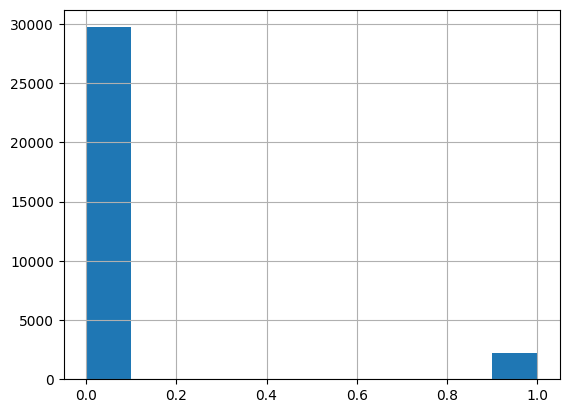

In [28]:
twidder_train.label.hist()

In [ ]:
print(my_tokenizer(twidder_train.tweet))

0                       user when a father is and is so selfish he his into his dysfunction run
1                             user user thanks for credit i can t use cause they don t offer in
2                                                                                  your majesty
3                                                    model i love u take with u all the time in
4                                                                        society now motivation
                                                  ...                                          
31957                                                                             ate user that
31958    to see turner on the trying to wrap herself in the mantle of a genuine hero like shame
31959                                              listening to sad on a morning to work is sad
31960                                                                     user temple in in act
31961                                   

In [ ]:
type(my_tokenizer(twidder_train.tweet)), type(twidder_train.tweet)

(pandas.core.series.Series, pandas.core.series.Series)

In [19]:
R = my_tokenizer(twidder_train.tweet)
M = twidder_train['label']


R_train, R_test, M_train, M_test = train_test_split(R, M, test_size=0.3, random_state=42)

# pipeline with CountVectorizer, TruncatedSVD and LogisticRegression
cleaned_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', LogisticRegression())  #logistic regression for sentiment classification
])

In [20]:
# Fit the pipeline on the training data
cleaned_pipeline.fit(R_train, M_train)

R_pred = cleaned_pipeline.predict(R_test)
accuracy = accuracy_score(M_test, R_pred)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9325268536865158


In [21]:
cm= confusion_matrix(M_test, R_pred)
cm

array([[8870,   35],
       [ 612,   72]])

In [22]:
f1sc = f1_score(M_test, R_pred)
f1sc

0.18204804045512007

In [23]:
clean_test_data= my_tokenizer(test_df.tweet)
R_test_pred = cleaned_pipeline.predict(clean_test_data)

In [24]:
test_df['clean_preds'] = R_test_pred
test_df

id  \
0      31963   
1      31964   
2      31965   
3      31966   
4      31967   
...      ...   
17192  49155   
17193  49156   
17194  49157   
17195  49158   
17196  49159   

                                                                                                                                                   tweet  \
0                                                             #studiolife #aislife #requires #passion #dedication #willpower   to find #newmaterialsâ¦    
1                                                   @user #white #supremacists want everyone to see the new â  #birdsâ #movie â and hereâs why     
2                                                                                safe ways to heal your #acne!!    #altwaystoheal #healthy   #healing!!    
3         is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð   #harrypotter #pottermore #favorite   
4                                                            3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦    
...                                                                                                                                                  ...   
17192                                       thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics  #brexit #blm &gt;3    
17193                                                   feeling like a mermaid ð #hairflip #neverready #formal #wedding #gown #dresses #mermaid  â¦    
17194  #hillary #campaigned today in #ohio((omg)) &amp; used words like "assets&amp;liability" never once did #clinton say thee(word) #radicalization      
17195                                           happy, at work conference: right mindset leads to culture-of-development organizations    #work #mindset   
17196                                                                                   my   song "so glad" free download!  #shoegaze #newmusic #newsong   

       clean_preds  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
17192            0  
17193            0  
17194            0  
17195            0  
17196            0  

[17197 rows x 3 columns]

In [25]:
R_arr = np.where(test_df.clean_preds == 1)

In [26]:
for i in R_arr[0]:
  print(test_df.tweet[i]+ "\n\n")

you might be a libtard if... #libtard  #sjw #liberal #politics 


#people aren't protesting #trump because a #republican won-they do so because trump has fuhered  &amp;â¦ 


the price of a stolen payment-card record has dropped from $25 in 2011 to $6 in 2016. this is why ransomware is on the rise  


#hate, , #crisis these are among many others the #president #elect @user &amp; his co are only capable 


@user @user @user us gun laws. that's why.  


@user #obama &amp; #hillary have divided america!  "arrest made in  burning of black church: #black suspect arrested"â¦ 


are you #black &amp; feel like the  are stomping on you? â¦  #retweet #tampa #miamiâ¦ 


trump said he didn't understand anything the president said. trump just admitted he is stupid. dumbest ever.   #dumbasstrump


2016- white man can act like a kid on twitter is called passionate, but when a black man says he would win, he has an ego.  


@user you might be a libtard if... #libtard  #sjw #liberal #politics 


#pe

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
class CosineSimilarityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        train_vectors = X[0]
        test_vectors = X[1]
        similarities = cosine_similarity(train_vectors, test_vectors)
        sorted_scores = np.argsort(-similarities, axis=0)
        return sorted_scores.ravel()

In [44]:
R_train.shape

(22373,)

In [30]:
cos_cleaned_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('svd', TruncatedSVD(n_components=100)),
    ('svm', svm.SVC())  #logistic regression for sentiment classification
])
# Fit the pipeline on the training data
cos_cleaned_pipeline.fit(R_train.values, M_train.values)

R_predz = cos_cleaned_pipeline.predict(R_test.values)
accuracy = accuracy_score(M_test, R_predz)
print("Accuracy:", accuracy)
f1sc = f1_score(M_test, R_predz)
f1sc

Accuracy: 0.9336740014600062


0.13114754098360656

In [ ]:
#@title Default title text
class CosineSimilarityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        train_vectors = X[0]
        test_vectors = X[1]
        train_vectors_2d = train_vectors.reshape(-1, train_vectors.shape[-1])
        test_vectors_2d = test_vectors.reshape(-1, test_vectors.shape[-1])

        similarities = cosine_similarity(train_vectors_2d, test_vectors_2d)
        sorted_scores = np.argsort(-similarities, axis=0)
        return sorted_scores.ravel()


# Define the pipeline
cos_cleaned_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('svd', TruncatedSVD(n_components=100)),
    ('cosine_similarity', CosineSimilarityTransformer()),
    ('clf', LogisticRegression())  # Logistic regression for sentiment classification
])

# Fit the pipeline on the training data
cos_cleaned_pipeline.fit(R_train.values.reshape(-1,1), M_train.values.reshape(-1,1))

# Predict on the test data
R_predz = cos_cleaned_pipeline.predict(R_test)
accuracy = accuracy_score(M_test, R_predz)
print("Accuracy:", accuracy)
f1sc = f1_score(M_test, R_predz)
print("F1 score:", f1sc)


In [59]:
type(R_train.values)

numpy.ndarray

In [76]:
R_train.values.astype(pd.Series).reshape(-1,1)

array([['summer swimming'],
       ['will show on snap twitter more attention then dey do their own girl but true'],
       ['when you are you boost your immune system and allow your to use the energy'],
       ...,
       ['black professor about an entire race whilst speaking for entire race next week the'],
       ['is total liberal trash its pathetic'],
       ['what people is relative we have our way']], dtype=object)

In [75]:
R_train.values[0]

'summer swimming'